# Plotting glider tracks

_Written by Lori Garzio, June 14, 2023_

[Rutgers Center for Ocean Observing Leadership](https://rucool.marine.rutgers.edu/) (RUCOOL)

This notebook shows you how to plot glider tracks on a map along with bathymetry. The glider track will be colored by time to give you a sense of where the glider was at what time. In this example we will be using data manually downloaded from the [IOOS Glider DAC ERDDAP server](https://gliders.ioos.us/erddap/index.html). See the download_data_dac notebook for detailed instructions.

In [1]:
# import required packages
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo

Specify the file paths for the dataset you would like to plot and the bathymetry data file. Load the datasets using xarray.

In [2]:
f = '/Users/garzio/Documents/rucool/gliderdata/ru30-20210716T1804-delayed.nc'
bathymetry = '/Users/garzio/Documents/rucool/bathymetry/GEBCO_2014_2D_-100.0_0.0_-10.0_50.0.nc'

ds = xr.open_dataset(f)
bathy_ds = xr.open_dataset(bathymetry)

Specify where you want the plot to be saved on your local machine.

In [3]:
save_dir = '/Users/garzio/Documents/rucool/gliderplots'

Look at the dataset for variables, time range, etc.

In [4]:
ds

<xarray.Dataset>
Dimensions:                         (row: 1894148)
Dimensions without coordinates: row
Data variables: (12/28)
    time                            (row) datetime64[ns] ...
    latitude                        (row) float64 ...
    longitude                       (row) float64 ...
    depth                           (row) float32 ...
    aragonite_saturation_state      (row) float32 ...
    chlorophyll_a                   (row) float32 ...
    ...                              ...
    salinity_interpolated           (row) float32 ...
    salinity_lag_shifted            (row) float32 ...
    temperature                     (row) float32 ...
    temperature_interpolated        (row) float32 ...
    temperature_lag_shifted         (row) float32 ...
    total_alkalinity                (row) float32 ...
Attributes: (12/59)
    acknowledgment:                This deployment supported by the NOAA Ocea...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    comment:                       Glider operated by the Rutgers University ...
    contributor_name:              Grace Saba, Theodore Thompson, Dave Aragon...
    ...                            ...
    subsetVariables:               wmo_id,trajectory,profile_id,time,latitude...
    summary:                       This project is conducting seasonal deploy...
    time_coverage_end:             2021-08-20T16:56:16.31Z
    time_coverage_start:           2021-07-16T18:06:48.11Z
    title:                         ru30-20210716T1804-delayed
    Westernmost_Easting:           -74.59385

Swap the dimensions to 'time'. This makes it easier to subset the dataset by time if you want to do that for any reason. 

In [5]:
ds = ds.swap_dims({'row': 'time'})

Get the deployment name from the global attributes and find the minimum and maximum timestamps - I usually put these in the title of the plot.

In [6]:
deployment_id = ds.title
t0 = pd.to_datetime(np.nanmin(ds.time)).strftime('%Y-%m-%dT%H:%M')
tf = pd.to_datetime(np.nanmax(ds.time)).strftime('%Y-%m-%dT%H:%M')
title = f'{deployment_id}\n{t0} to {tf}'
print(title)

ru30-20210716T1804-delayed
2021-07-16T18:06 to 2021-08-20T16:56


Define the bounding box for the plotting function by grabbing the latitude and longitude from the glider and add a buffer. This avoids having to manually set the extent for the plotting function.

In [7]:
extent = [np.nanmin(ds.longitude.values) - 2, np.nanmax(ds.longitude.values) + 2,
          np.nanmin(ds.latitude.values) - 1.5, np.nanmax(ds.latitude.values) + 1.5]
print(extent)

[-76.59385, -71.08392, 36.64329, 40.93324]


Subset the bathymetry dataset using your plotting limits so you aren't trying to plot a large amount of data, and grab the data from the file (latitude, longitude, and elevation.

In [8]:
bathy_ds = bathy_ds.sel(lon=slice(extent[0], extent[1]),
                        lat=slice(extent[2], extent[3]))

levels = np.arange(-5000, 5100, 50)
bath_lat = bathy_ds.variables['lat'][:]
bath_lon = bathy_ds.variables['lon'][:]
bath_elev = bathy_ds.variables['elevation'][:]
bath_elev

<xarray.Variable (lat: 515, lon: 661)>
[340415 values with dtype=float64]
Attributes:
    standard_name:       height_above_reference_ellipsoid
    long_name:           Elevation relative to sea level
    units:               m
    sdn_parameter_urn:   SDN:P01::BATHHGHT
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06:ULAA
    sdn_uom_name:        Metres

Now we can set up the plot and adjust the side margin so we can add the timestamps to the colorbar. Then first add the bathymetry data as your first layer in the plot. Here we use the [cmocean colormap](https://matplotlib.org/cmocean/) "topo" for the topography/bathymetry. We will also add a dotted line to highlight more of the features on the shelf, add more features like state lines and rivers, add gridlines, and add labels for the coordinates. Then plot all of the glider coorinates in black as a background color, and add the coordinates with colors according to time. And finally add a colorbar showing which colors coordinate with which times. This will take a few seconds because we're plotting a lot of data. To save the plot to your computer it needs to be done in this same block of code.

/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_30090/3573160175.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.ax.get_yticks()).strftime(date_format='%Y-%m-%d'))


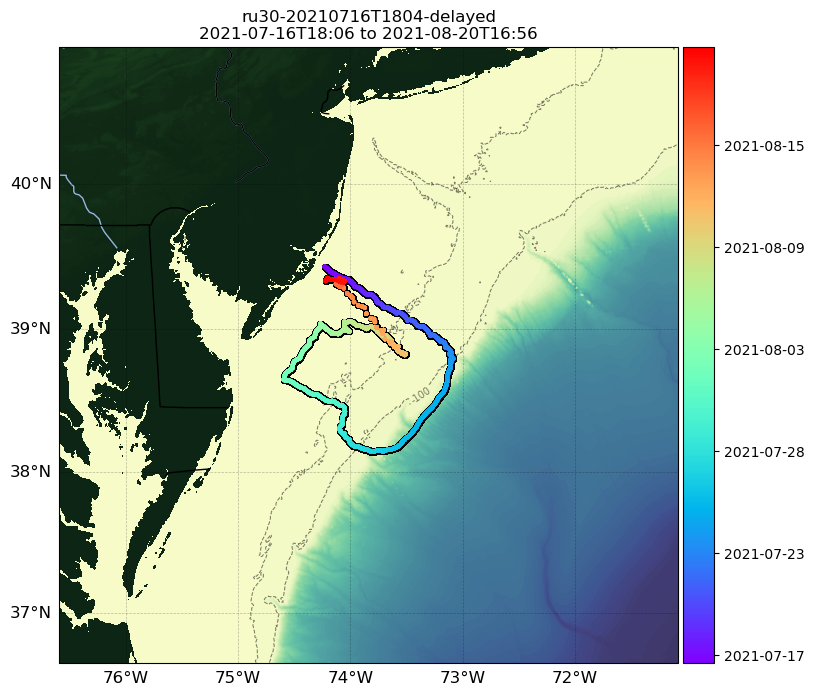

In [9]:
fig, ax = plt.subplots(figsize=(11, 8), subplot_kw=dict(projection=ccrs.Mercator()))
plt.subplots_adjust(right=0.82)  # adjust margins for colorbar

# add bathymetry/topography as a colormap
plt.contourf(bath_lon, bath_lat, bath_elev, levels, cmap=cmo.cm.topo, transform=ccrs.PlateCarree())

# add dotted lines
levels = np.arange(-100, 0, 50)
CS = plt.contour(bath_lon, bath_lat, bath_elev, levels, linewidths=.75, alpha=.5, colors='k',
                 transform=ccrs.PlateCarree())
ax.clabel(CS, [-100], inline=True, fontsize=7, fmt='%d')  # add a label at the 100m isobath

# add additional features
state_lines = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(state_lines)

# specify the limits of the map
ax.set_extent(extent)
               
# Gridlines and grid labels
gl = ax.gridlines(
    draw_labels=True,
    linewidth=.5,
    color='black',
    alpha=0.25,
    linestyle='--'
)
               
# latitude and longitude labels
gl.top_labels = gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# get the glider coordinates and add those as points on the map
lon = ds.longitude.values
lat = ds.latitude.values

ax.scatter(lon, lat, color='k', marker='.', s=60, transform=ccrs.PlateCarree(), zorder=10)
sct = ax.scatter(lon, lat, c=ds.time.values, marker='.', s=15, cmap='rainbow', 
                 transform=ccrs.PlateCarree(), zorder=10)

# add the plot title
plt.title(title, fontsize=12)

# Set colorbar height equal to plot height
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

# generate colorbar
cbar = plt.colorbar(sct, cax=cax)
cbar.ax.set_yticklabels(pd.to_datetime(cbar.ax.get_yticks()).strftime(date_format='%Y-%m-%d'))

# save the plot to your local machine
fname = f'{deployment_id}_glider-track.png'
save_name = os.path.join(save_dir, fname)
plt.savefig(save_name, dpi=300)

Print where you saved the plot so you can find it (yes we've all had that problem!) and close the plot.

In [10]:
plt.close()
print(f'File saved to: {save_name}')

File saved to: /Users/garzio/Documents/rucool/gliderplots/ru30-20210716T1804-delayed_glider-track.png
